In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [16]:
df = pd.read_csv('consumption.csv')
df.columns = ['a','b','c','d','e']
df.drop(['b','c','d'], axis=1, inplace=True)
df.columns = ['datetime','Consumption_MWh']
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.head()

,Consumption_MWh
datetime,
2018-12-31 21:00:00,11291.0
2018-12-31 22:00:00,10816.0
2018-12-31 23:00:00,10467.0
2019-01-01 00:00:00,10152.0
2019-01-01 01:00:00,9920.0


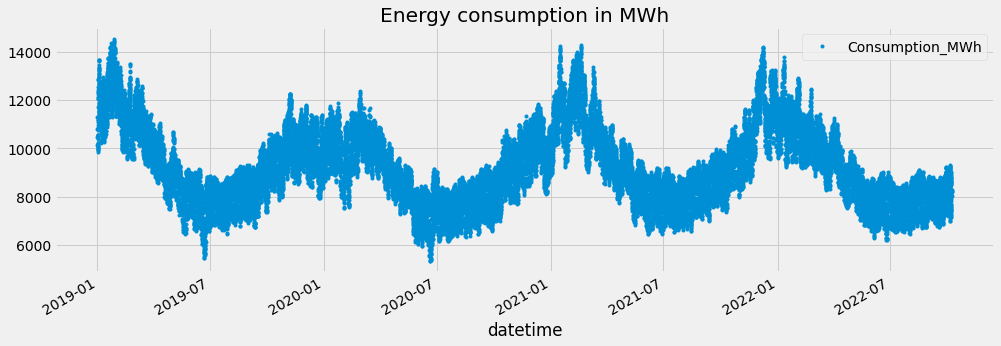

In [17]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Energy consumption in MWh')
plt.show()

### Outlier detection and removal

<AxesSubplot:ylabel='Frequency'>

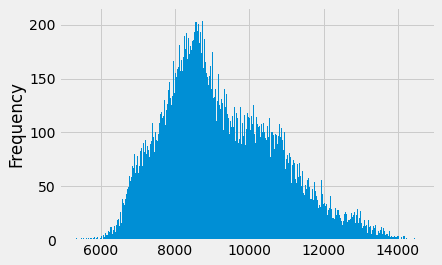

In [18]:
df['Consumption_MWh'].plot(kind='hist', bins=500)

### Save data to parquet file

In [19]:
df.to_parquet('processed_data/consumption.parquet')

### Create time series features

In [20]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

### Create lag features

In [21]:
def add_lags(df):
    target_map = df['Consumption_MWh'].to_dict()
    df['c_lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['c_lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['c_lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

df = add_lags(df)

### Train XGBoost model

In [22]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'c_lag1','c_lag2','c_lag3']
TARGET = 'Consumption_MWh'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = XGBRegressor(n_estimators=1000)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:6593.46003
[100]	validation_0-rmse:174.71640
[200]	validation_0-rmse:125.51884
[300]	validation_0-rmse:104.46417
[400]	validation_0-rmse:89.05544
[500]	validation_0-rmse:79.02921
[600]	validation_0-rmse:71.27210
[700]	validation_0-rmse:64.91020
[800]	validation_0-rmse:59.80125
[900]	validation_0-rmse:55.18028
[999]	validation_0-rmse:50.77314


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

### Predict the future

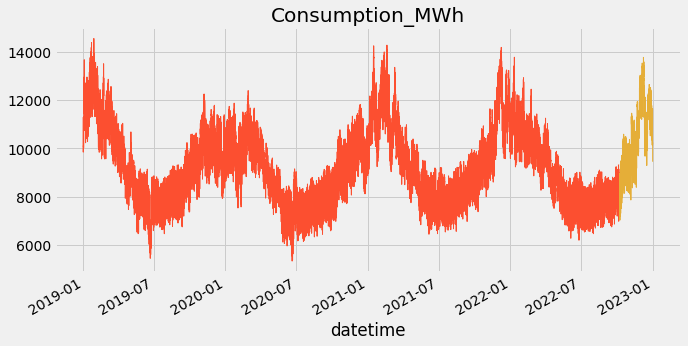

In [23]:
# Create future dataframe
future = pd.date_range(df.index.max(),'2023-01-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)
future_w_features = df_and_future.query('isFuture').copy()

future_w_features['Consumption_MWh'] = reg.predict(future_w_features[FEATURES])

ax = df['Consumption_MWh'].plot(figsize=(10, 5),
                               color=color_pal[1],
                               ms=1,
                               lw=1)
future_w_features['Consumption_MWh'].plot(ax=ax, color=color_pal[2],ms=1,lw=1, title='Consumption_MWh')
plt.show()  

In [24]:
future_w_features[['Consumption_MWh','c_lag1','c_lag2','c_lag3']].to_parquet('../future_data/consumption.parquet')